In [1]:
%run setup_PS_data_multi.ipynb
import pandas as pd
import math, cmath
from tqdm import tqdm
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')

ERROR:root:File `'setup_notebook.ipynb.py'` not found.


Now loading mouse RL032, run 7
error in mouse RL032, run 7
Now loading mouse RL032, run 10
error in mouse RL032, run 10
Now loading mouse RL032, run 12
error in mouse RL032, run 12
Now loading mouse RL032, run 13
error in mouse RL032, run 13
Now loading mouse RL022, run 5
error in mouse RL022, run 5
Now loading mouse RL022, run 7
error in mouse RL022, run 7
Now loading mouse RL022, run 11
error in mouse RL022, run 11
Now loading mouse RL022, run 13
error in mouse RL022, run 13
Now loading mouse RL022, run 14
error in mouse RL022, run 14
Now loading mouse RL023, run 5
error in mouse RL023, run 5
Now loading mouse RL023, run 7
error in mouse RL023, run 7
Now loading mouse RL023, run 8
error in mouse RL023, run 8
Now loading mouse RL023, run 9
error in mouse RL023, run 9
Now loading mouse RL023, run 11
error in mouse RL023, run 11
Now loading mouse RL023, run 12
error in mouse RL023, run 12
Now loading mouse J047, run 7
error in mouse J047, run 7
Now loading mouse J048, run 15
error in mo

# START

In [2]:
  # determine regularizer param with CV on training data
  #NB: have not tried to implement this yet
  # train /test  folds

def fun_return_2d(data):  # possibly add fancy stuff
    return np.mean(data, 2)

def angle_vecs(v1, v2):
    assert v1.shape == v2.shape
    v1, v2 = np.squeeze(v1), np.squeeze(v2)
    tmp = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    rad = np.arccos(tmp)
    deg = rad * 360 / (2 * np.pi)
    return deg

def mean_angle(deg):
    return math.degrees(cmath.phase(sum([cmath.rect(1, math.radians(d)) for d in deg])/len(deg)))


def create_dict_pred(nl, train_proj, lt):
        dict_predictions_test = {x + '_test': np.array([]) for x in nl}  # make dicts to save
        dict_predictions_train = {x + '_train': np.array([]) for x in nl}
        if train_proj:
            for x in lt:
                dict_predictions_train[f'pred_{x}_train_proj'] = np.array([])
                dict_predictions_test[f'pred_{x}_test_proj'] = np.array([])
        if len(lt) == 2:
            dict_predictions_train['angle_decoders'] = np.array([])
        return dict_predictions_train, dict_predictions_test

# for ii in range(len(sessions)):
#     sessions[ii].shuffle_labels()


In [3]:
def train_test_all_sessions(trial_times_use=None, verbose=2, list_test = ['dec', 'stim'],
                            hitmiss_only=False, cv_regularizer = False, include_150 = False,
                            n_split = 4, include_autoreward=True, neurons_selection='all',
                            C_value=0.2, train_projected=False):
    if hitmiss_only:
        if verbose >= 1:
            print('Using hit/miss trials only.')
        if 'stim' in list_test:
            list_test.remove('stim')  # no point in estimating stim, because only PS
            
    name_list = ['autorewarded']  # names of details to save - whether autorewrd trial or not
    for nn in list_test:
        name_list.append('pred_' + nn)  # prediction
    for nn in ['dec', 'stim']:
        name_list.append('true_' + nn)  # ground truth
        
    mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
    df_prediction_train, df_prediction_test = dict(), dict()
    for mouse in mouse_list:
        angle_decoders = np.zeros((len(sessions), n_split))
        dict_predictions_train, dict_predictions_test = create_dict_pred(nl=name_list, train_proj=train_projected, lt=list_test)
        for i_session, session in sessions.items():  # loop through sessions/runs and concatenate results (in dicts)
            if session.mouse == mouse:  # only evaluate current mouse
                if verbose >= 1:
                    print(f'Mouse {mouse}, Starting loop {i_session + 1}/{len(sessions)}')
                if trial_times_use is None:
                    trial_times_use = session.filter_ps_array[(session.final_pre_gap_tp + 1):(session.final_pre_gap_tp + 6)]
                    print('WARNING: trial_times undefined so hard-coding them (to 5 post-stim frames)')
                n_trial_times_used = len(trial_times_use)

                ## Set neuron inds
                if neurons_selection == 'all':
                    neurons_include = np.arange(session.behaviour_trials.shape[0])
                elif neurons_selection == 's1':
                    neurons_include = session.s1_bool
                elif neurons_selection == 's2':
                    neurons_include = session.s2_bool

                ## Set trial inds
                if include_150 is False:
                    trial_inds = np.where(session.photostim < 2)[0]
                else:
                    trial_inds = np.arange(len(session.photostim))

                if hitmiss_only:
                    hitmiss_trials = np.where(np.logical_or(sessions[0].outcome == 'hit', sessions[0].outcome == 'miss'))[0]
                    if verbose == 2:
                        print(f'Size hm {hitmiss_trials.size}, trial inds {trial_inds.size}')
                    trial_inds = np.intersect1d(trial_inds, hitmiss_trials)

                if include_autoreward is False:
                    ar_exclude = np.where(session.autorewarded == False)[0]
                    if verbose == 2:
                        print(f'{np.sum(session.autorewarded)} autorewarded trials found and excluded')
                    trial_inds = np.intersect1d(trial_inds, ar_exclude)

                if verbose == 2:
                    print(f'final size {trial_inds.size}')
                n_trials = len(trial_inds)
                if verbose == 2:
                    print(f'Total number of trials is {n_trials}. Number of splits is {n_split}')

                # Prepare data with selections
                data_use = session.behaviour_trials[neurons_include, :, :]
                data_use = data_use[:, :, trial_times_use]
                data_use = data_use[:, trial_inds, :]
                data_use = fun_return_2d(data_use)
                stand_scale = sklearn.preprocessing.StandardScaler()
                data_use = stand_scale.fit_transform(data_use)
        #         sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=n_split, test_size=int(np.round(len(trial_inds) / n_split)))  # split into n_split data folds of trials

                sss = sklearn.model_selection.StratifiedKFold(n_splits=n_split)  # split into n_split data folds of trials
                if verbose == 2:
                    print(f'Number of licks: {np.sum(session.decision[trial_inds])}')
                    dict_outcomes = {x: np.sum(session.outcome[trial_inds] == x) for x in np.unique(session.outcome[trial_inds])}
                    print(f'Possible trial outcomes: {dict_outcomes}')
                    dict_n_ps = {x: np.sum(session.trial_subsets[trial_inds] == x) for x in np.unique(session.trial_subsets[trial_inds])}
                    print(f'Possible stimulations: {dict_n_ps}')
                i_loop = 0    
                for train_inds, test_inds in sss.split(X=np.zeros(n_trials), y=session.outcome[trial_inds]):  # loop through different train/test folds, concat results
                    train_data, test_data = data_use[:, train_inds], data_use[:, test_inds]
                    if i_loop == 0:
                        if verbose == 2:
                            print(f'Shape train data {train_data.shape}, test data {test_data.shape}')

                    ## Get labels and categories of trials
                    train_labels = {'stim': session.photostim[trial_inds[train_inds]],
                                    'dec': session.decision[trial_inds[train_inds]]}
                    test_labels = {'stim': session.photostim[trial_inds[test_inds]], 
                                   'dec': session.decision[trial_inds[test_inds]]}
                    if verbose == 2:
                        print(f' Number of test licks {np.sum(test_labels["dec"])}')
                    detailed_ps_labels = session.trial_subsets[trial_inds]
                    autorewarded = session.autorewarded[trial_inds]
                    assert len(train_labels['dec']) == train_data.shape[1]
                    assert len(test_labels['stim']) == test_data.shape[1]

                    ## Train logistic regression model on train data
                    dec = {}
                    if cv_regularizer:  # optimise regularizer param
                        reg_array = {'C': np.logspace(-3, 0, 20), 'class_weight': ['balanced']}
                        for x in list_test:
                            grid = sklearn.model_selection.GridSearchCV(sklearn.linear_model.LogisticRegression(),
                                                                        reg_array, cv=n_split)
                            grid.fit(X=train_data.transpose(), y=train_labels[x])
                            if verbose == 2:
                                print(grid.best_params_)
                            dec[x] = sklearn.linear_model.LogisticRegression(C=grid.best_params_['C'],
                                                                 class_weight='balanced').fit(
                                    X=train_data.transpose(), y=train_labels[x])
                    else:
                        for x in list_test:
                            dec[x] = sklearn.linear_model.LogisticRegression(C=C_value, class_weight='balanced').fit(
                                            X=train_data.transpose(), y=train_labels[x])

                    if len(list_test) == 2:
                        angle_decoders[i_session, i_loop] = angle_vecs(dec[list_test[0]].coef_, dec[list_test[1]].coef_)

                    if train_projected:  # project and re decode
                        dec_proj = {}
                        assert len(list_test) == 2  # hard coded that len==2 further on
                        for i_x, x in enumerate(list_test):
                            i_y = 1 - i_x
                            y = list_test[i_y]
                            assert x != y
                            train_data_proj = dec[y].coef_ *  train_data.transpose()
                            test_data_proj = dec[y].coef_ *  test_data.transpose()
                            dec_proj[x] = sklearn.linear_model.LogisticRegression(C=C_value, class_weight='balanced').fit(
                                            X=train_data_proj, y=train_labels[x])

                    ## Predict test data
                    pred_proba_train = {x: dec[x].predict_proba(X=train_data.transpose())[:, 1] for x in list_test}
                    pred_proba_test = {x: dec[x].predict_proba(X=test_data.transpose())[:, 1] for x in list_test}
                    if train_projected:
                        pred_proba_train_proj = {x: dec_proj[x].predict_proba(X=train_data_proj)[:, 1] for x in list_test}
                        pred_proba_test_proj = {x: dec_proj[x].predict_proba(X=test_data_proj)[:, 1] for x in list_test}

                    ## Save results
                    for x in list_test: 
                        dict_predictions_train[f'pred_{x}_train'] = np.concatenate((dict_predictions_train[f'pred_{x}_train'], pred_proba_train[x]))
                        dict_predictions_test[f'pred_{x}_test'] = np.concatenate((dict_predictions_test[f'pred_{x}_test'], pred_proba_test[x]))
                        if train_projected:
                            dict_predictions_train[f'pred_{x}_train_proj'] = np.concatenate((dict_predictions_train[f'pred_{x}_train_proj'], pred_proba_train_proj[x]))
                            dict_predictions_test[f'pred_{x}_test_proj'] = np.concatenate((dict_predictions_test[f'pred_{x}_test_proj'], pred_proba_test_proj[x]))
                    if len(list_test) == 2:
                        dict_predictions_train['angle_decoders'] = np.concatenate((dict_predictions_train['angle_decoders'], np.zeros_like(pred_proba_train[x]) + angle_decoders[i_session, i_loop]))
                    dict_predictions_train['true_stim_train'] = np.concatenate((dict_predictions_train['true_stim_train'], detailed_ps_labels[train_inds]))
                    dict_predictions_test['true_stim_test'] = np.concatenate((dict_predictions_test['true_stim_test'], detailed_ps_labels[test_inds]))
                    dict_predictions_train['autorewarded_train'] = np.concatenate((dict_predictions_train['autorewarded_train'], autorewarded[train_inds]))
                    dict_predictions_test['autorewarded_test'] = np.concatenate((dict_predictions_test['autorewarded_test'], autorewarded[test_inds]))
                    dict_predictions_train['true_dec_train'] = np.concatenate((dict_predictions_train['true_dec_train'], train_labels['dec']))
                    dict_predictions_test['true_dec_test'] = np.concatenate((dict_predictions_test['true_dec_test'], test_labels['dec']))
                    i_loop += 1
        if verbose == 2:
            print(f'length test: {len(dict_predictions_test["true_dec_test"])}')

        ## Put dictionary results into dataframes:
        df_prediction_train[mouse] = pd.DataFrame(dict_predictions_train)
        df_prediction_test[mouse] = pd.DataFrame(dict_predictions_test)
    return df_prediction_train, df_prediction_test

Mouse J048, Starting loop 1/7
Mouse J048, Starting loop 2/7
Mouse J048, Starting loop 3/7
Mouse J048, Starting loop 4/7
Mouse RL048, Starting loop 5/7
Mouse RL048, Starting loop 6/7
Mouse RL048, Starting loop 7/7


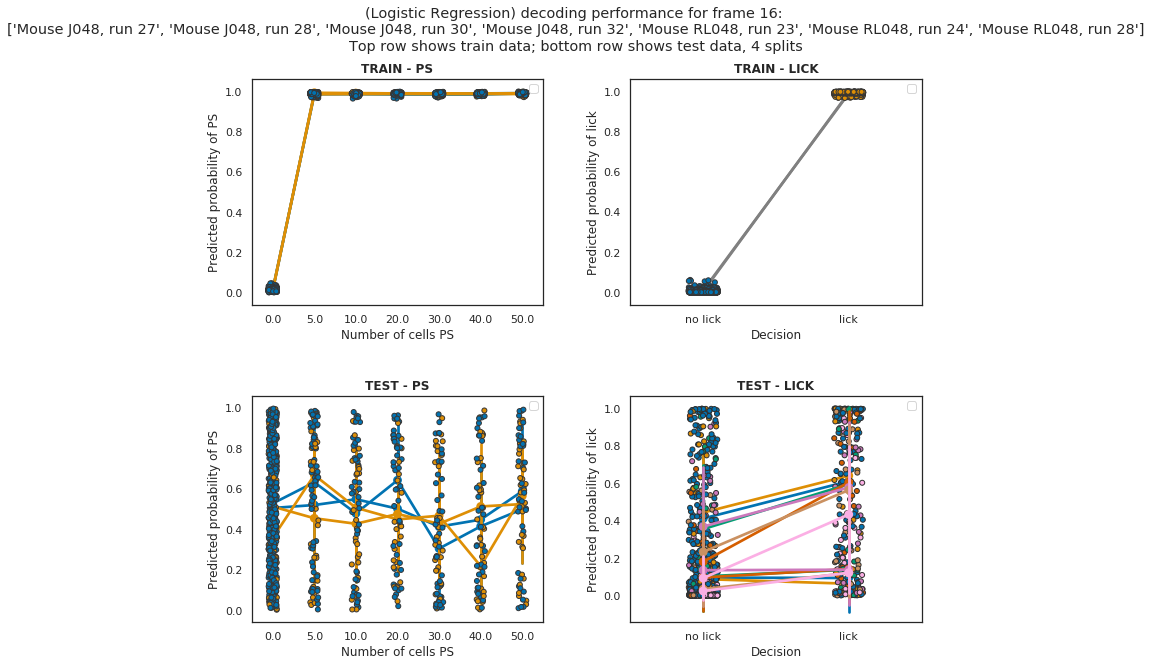

In [4]:
time_frame = 16
n_splits = 4

df_prediction_train, df_prediction_test = train_test_all_sessions(verbose=1, n_split=n_splits,
                                              trial_times_use=np.array([time_frame]),
                                         hitmiss_only=False,# list_test=['dec', 'stim'],
                                         include_autoreward=True, neurons_selection='all',
                                         C_value=0.2, cv_regularizer=False, train_projected=False)

plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

def plot_df_stats(df, xx, yy, hh, plot_line=True, xticklabels=None):
#     yy = yy + '_proj'
    if plot_line and hh is None:
        sns.pointplot(data=df, x=xx, y=yy, color='grey', ci='sd')
    elif plot_line and hh is not None:
        sns.pointplot(data=df, x=xx, y=yy, hue=hh, ci='sd')
#     elif plot_line and hh is not None:
        
    tmp = sns.stripplot(x=xx, y=yy, hue=hh, data=df, linewidth=1)
    if xticklabels is not None:
        tmp.set_xticklabels(xticklabels)
    
## NB: To not plot with hue, set hh=None
for mouse in df_prediction_train.keys():
    if 'pred_stim_train' in df_prediction_train[mouse].columns:
        plt.subplot(221)
        plot_df_stats(df=df_prediction_train[mouse], xx='true_stim_train', yy='pred_stim_train', hh='true_dec_train')  # set hh=None or hh='dec_train'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')
        plt.legend([])

        plt.subplot(223)
        plot_df_stats(df=df_prediction_test[mouse], xx='true_stim_test', yy='pred_stim_test', hh='true_dec_test')  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')
        plt.legend([])

    if 'pred_dec_train' in df_prediction_train[mouse].columns:  
        plt.subplot(222)
        plot_df_stats(df=df_prediction_train[mouse], xx='true_dec_train', yy='pred_dec_train', hh=None, xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')
        plt.legend('No lick', 'lick')

        plt.subplot(224)
        plot_df_stats(df=df_prediction_test[mouse], xx='true_dec_test', yy='pred_dec_test', hh='true_stim_test', xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');
        plt.legend([])
plt.suptitle(f'(Logistic Regression) decoding performance for frame {time_frame}: \n{[str(sessions[x]) for x in range(len(sessions))]}\n' + 
#              f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
             f'Top row shows train data; bottom row shows test data, {n_splits} splits\n');

## Dynamic coding:

In [5]:

def prob_correct(binary_truth, estimate):    
    """where bt = {0, 1} and est = (0, 1)"""
    prob = (binary_truth * estimate + (1 - binary_truth) * (1 - estimate))
    return prob

def mean_accuracy(binary_truth, estimate):
    assert len(binary_truth) == len(estimate)
    pp = prob_correct(binary_truth=binary_truth, estimate=estimate)
    return np.mean(pp), np.std(pp)

def mean_accuracy_pred(binary_truth, estimate):
    round_est = np.round(estimate)
    return sklearn.metrics.accuracy_score(binary_truth, round_est), 0

def llh(binary_truth, estimate):
    assert len(binary_truth) == len(estimate)
    pp = prob_correct(binary_truth=binary_truth, estimate=estimate)
    llh = np.mean(np.log(np.clip(pp, a_min=1e-3, a_max=1)))
    return llh, 0

def r2_acc(binary_truth, estimate):
    return sklearn.metrics.r2_score(y_true=binary_truth, y_pred=estimate), 0
                  
average_fun = mean_accuracy    

mouse_list = list(df_prediction_train.keys())
n_timepoints = len(sessions[0].filter_ps_array)
cv_regularizer = False
lick_acc = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_list} #mean, std
lick_half = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_list}
lick_acc_split = {mouse: {x: np.zeros((n_timepoints, 2)) for x in df_prediction_test[mouse_list[0]]['true_stim_test'].unique()} for mouse in mouse_list}
ps_acc = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_list}
ps_acc_split = {mouse: {x: np.zeros((n_timepoints, 2)) for x in df_prediction_test[mouse_list[0]]['true_dec_test'].unique()} for mouse in mouse_list}
    
    
for i_tp, tp in tqdm(enumerate(sessions[0].filter_ps_array)):
    df_prediction_train, df_prediction_test = train_test_all_sessions(trial_times_use=np.array([tp]), 
                                                  verbose=0, hitmiss_only=False,
                                                  include_autoreward=True, C_value=0.2,
                                                  cv_regularizer=False, train_projected=False)
    
    for mouse in df_prediction_train.keys():
        lick = df_prediction_test[mouse]['true_dec_test']
        ps = (df_prediction_test[mouse]['true_stim_test'] > 0).astype('int')
        pred_lick = df_prediction_test[mouse]['pred_dec_test']  # _proj
        lick_half[mouse][i_tp, :] = average_fun(binary_truth=lick, estimate=(np.zeros_like(lick) + 0.5))
        lick_acc[mouse][i_tp, :] = average_fun(binary_truth=lick, estimate=pred_lick)
        for x, arr in lick_acc_split[mouse].items():
            arr[i_tp, :] = average_fun(binary_truth=lick[np.where(df_prediction_test[mouse]['true_stim_test'] == x)[0]], 
                                      estimate=pred_lick[np.where(df_prediction_test[mouse]['true_stim_test'] == x)[0]])

        if 'pred_stim_test' in df_prediction_test[mouse].columns:
            pred_ps = df_prediction_test[mouse]['pred_stim_test']  # _proj
            ps_acc[mouse][i_tp, :] = average_fun(binary_truth=ps, estimate=pred_ps)
            for x, arr in ps_acc_split[mouse].items():
                arr[i_tp, :] = average_fun(binary_truth=ps[np.where(lick == x)[0]], 
                                          estimate=pred_ps[np.where(lick == x)[0]])

46it [01:56,  2.53s/it]


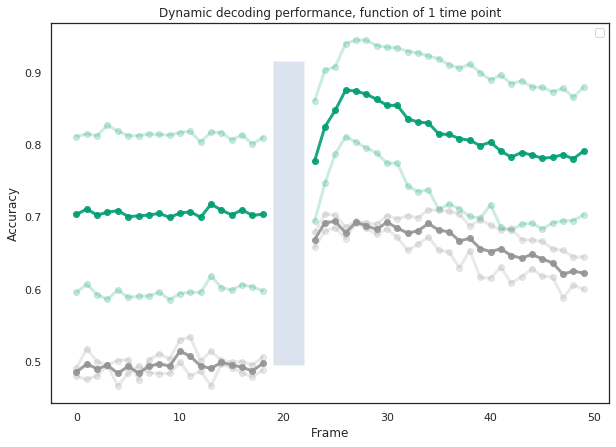

In [9]:
plt.rcParams['figure.figsize'] = (10, 7)
ax_acc = plt.subplot(111)

color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break
        
def plot_interrupted_trace(ax, plot_array, llabel='', bool_plot_std=False,
                           plot_laser=True, linest='-', ccolor='grey'):
    breakpoint = sessions[0].art_gap_start
    time_1 = sessions[0].filter_ps_array[:breakpoint]
    time_2 = sessions[0].filter_ps_array[breakpoint:]
    
    mouse_list = list(plot_array.keys())
    average_mean = np.zeros_like(plot_array[mouse_list[0]][:, 0])
    for mouse in mouse_list:
        assert len(plot_array[mouse].shape) == 2
        plot_mean = plot_array[mouse][:, 0]
        average_mean += plot_mean / len(mouse_list)
    #     plot_std = plot_array[:, 1]
    #     if bool_plot_std:
    #         ax_acc.fill_between(x=time_1, y1=plot_mean[:breakpoint] - plot_std[:breakpoint],
    #                            y2=plot_mean[:breakpoint] + plot_std[:breakpoint], color=ccolor, alpha=0.2)
    #         ax_acc.fill_between(x=time_2, y1=plot_mean[breakpoint:] - plot_std[breakpoint:],
    #                            y2=plot_mean[breakpoint:] + plot_std[breakpoint:], color=ccolor, alpha=0.2)

        ax_acc.plot(time_1, plot_mean[:breakpoint], '.-', linewidth=3, linestyle=linest, 
                    markersize=12, color=ccolor, label='' alpha=0.2)
        ax_acc.plot(time_2, plot_mean[breakpoint:], '.-', linewidth=3, linestyle=linest, 
                    markersize=12, color=ccolor, alpha=0.2)
    ax_acc.plot(time_1, average_mean[:breakpoint], '.-', linewidth=3, linestyle=linest, 
                    markersize=12, color=ccolor, label='', alpha=0.9)
    ax_acc.plot(time_2, average_mean[breakpoint:], '.-', linewidth=3, linestyle=linest, 
                markersize=12, color=ccolor, alpha=0.9)
    if plot_laser:
        ax_acc.axvspan(xmin=time_1[-1] + 1, xmax=time_2[0] - 1, ymin=0.1, ymax=0.9, alpha=0.1)
    return ax_acc

if 'pred_dec_test' in df_prediction_test[mouse_list[0]].columns:
    plot_interrupted_trace(ax=ax_acc
                           , plot_array=lick_acc, bool_plot_std=False,
                           llabel='decision', ccolor=(0.00784313725490196, 0.6196078431372549, 0.45098039215686275))
if 'pred_stim_test' in df_prediction_test[mouse_list[0]].columns:
    plot_interrupted_trace(ax=ax_acc, plot_array=ps_acc, llabel='ps', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

# plot_dict_split = lick_acc_split
# for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
#     dict_part = plot_dict_split[key]
#     plot_interrupted_trace(ax=ax_acc, plot_array=dict_part, llabel=str(key), ccolor=color_dict_stand[iplot])

# ax_acc.plot(sessions[0].filter_ps_array, np.zeros_like(sessions[0].filter_ps_array) - np.log(2),
#            ':k')
# plot_interrupted_trace(ax=ax_acc, plot_array=lick_half, bool_plot_std=False, llabel='0.5')
ax_acc.set_xlabel('Frame'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(); ax_acc.set_title('Dynamic decoding performance, function of 1 time point');
# plt.xlim([180, 220])

## ideas to improve / directions to go

#### Current plot:

- Quantify statistical significance between go/no go 
- S1 vs S2
- Distribution weight matrix
- plot \Delta W(t, t-1)

#### Try to find a function of the data that enhances the readout.

- Dimensionality reduction (dPCA should be ideal, theoretically)

- different integration of time points per neuron? (i.e. separate, some other function etc)

- Try to find something that relates PS decoding to licking decoding

#### S1 / S2 comparison

- Add dynamic prediction between populations -> subspaces -> Same question as with semedo data (i.e. different neurons that predict S2 or decode stim)

- We don't really find a difference between S1/S2 performance (-> large population?)

- Use increasing/decreasing number of neurons